# Auto Enconder Variacional (VAE)

~~~
Extracción de Características en Imágenes.
Master en Ciencia de Datos y Arquitectura de los Computadores.
Universidad de Granada.

Fernando Pérez Bueno - fpb@ugr.es
Rafael Molina Soriano - rms@decsai.ugr.es

~~~

En este guión veremos la implementación de una VAE en Keras. 
Esta implementación ha sido obtenida de los ejemplos de Keras
https://keras.io/examples/generative/vae/

En el post de towardsdatascience.com hay una explicación muy intuitiva y contiene algunos de los ejemplos que se han mencionado en clase.
https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

En este enlace puedes visualizar el contenido del espacio latente de una VAE entrenada con MNIST
http://taylordenouden.com/VAE-Latent-Space-Explorer/

Librerias que vamos a utilizar en el desarrollo de la práctica.

In [2]:
import numpy as np
import tensorflow as tf # versión minima para este codigo, tensorflow 2.2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print('Tu versión de tensorflow:',tf.__version__)

Tu versión de tensorflow: 2.4.1


# BLOQUE 1. Preguntas generales sobres las VAEs. Valor total de las respuestas 1 sobre 2 puntos

## Lectura de MNIST

Las redes neuronales requieren una cantidad de datos muy elevada para entrenar, por tanto, nuestro dataset de tan solo 5000 caras se queda pequeño. En esta ocasión vamos a trabajar con el popular dataset MNIST, que probablemente ya conozcas. Se trata de imágenes 28x28 de números manuscritos, con un total de 70.000 muestras.

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).\
            astype("float32") / 255

In [ ]:
mnist_digits.shape

In [ ]:
n_digitos=5
for i in range(n_digitos):
    plt.subplot(1,n_digitos,i+1)
    plt.imshow(mnist_digits[i,...,0],cmap='gray')

## Capa de muestreo

La capa de muestreo, nos permite extraer muestras de p(z|x) mediante la trampa de la reparametrización. Fijate que definimos como se obtiene una muestra utilizando una capa de tensorflow, para poder integrarla en el modelo.

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.\
        random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Construimos el codificador (Encoder)

Utilizaremos una red neuronal que será la encargada de representar p(z|x). Fijate que le pedimos dos salidas, media y varianza para explicar la variable latente.

La arquitectura es sencilla:

1. Comenzamos con imagenes en blanco y negro de 28x28 pixel
2. Una capa convolucional de 32 filtros 3x3 y tamaño de paso (stride) 2 . En los bordes, los filtros se rellenan con duplicados del valor del borde. Nuestro tamaño es ahora 32x14x14. Fijate que hemos usado una función de activación muy extendida, la ReLU
3. Una nueva capa convolucional de 63 filtros 3x3 y stride 2.
4. Una capa "flatten" para convertir cada conjunto de caracteristicas extraidas por los filtros en un vector.
5. Una capa intermedia, totalmente conectada, que comprime las caracteristicas a 16.
6. De forma paralela, la red se divide en dos:
    1. Una red totalmente conectada que extrae la media z según el tamaño de dimension latente especificado
    2. Una red totalmente conectada que extrae la varianza de z según el tamaño de dimensión latente. (Elementos de la diagonal)
7. Usando la función sampling que hemos definido en el paso anterior, obtenemos una muestra de z.

Observa que la orden encoder.summary() nos permite ver claramente el tamaño de nuestros datos en cada paso

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z],name="encoder")
encoder.summary()

<div class="alert alert-block alert-info">
<b> Dibuja la estructura del codificador. Puedes hacerlo a mano, luego hacerle una foto al gráfico e incluirlo aquí. Si lo prefieres utiliza alguna aplicación gráfica para dibujar la red. Del codificador no es necesario que incluyas la generación de la muestra.</b>
</div>

Incluye aquí tu gráfico.

##  Construcción del decoder

De la misma forma, construimos el decodificador que será p(x|z).

La estructura es similar:

0. Partimos de una muestra de z.
1. Una capa totalmente conectada, que obtiene un vector 7*7*64
2. Una redimensión para convertirla a las dimensiones con las que trabajan las capas convolucionales.
3. Una capa de convolución transpuesta de 64 filtros 3x3 y stride 2. En este caso, quiere decir que la salida será el doble del tamaño de la entrada.
4. Una capa de convolución transpuesta de 32 filtros 3x3 y de nuevo stride 2.
5. Una ultima capa de convolución transpuesta de 1 solo filtro 3x3. Fijate que ya teniamos el tamaño 28x28 y lo que hace esta capa es unificar las características de los 32 filtros a una sola imagen.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


<div class="alert alert-block alert-info">
<b> Dibuja la estructura del decodificador. Puedes hacerlo a mano, luego hacerle una foto al gráfico e incluirlo aquí. Si lo prefieres utiliza alguna aplicación gráfica para dibujar la red. </b>
</div>

Incluye aquí el decodificador



<div class="alert alert-block alert-info">
<b> En la última capa, hemos utilizado una sigmoide. ¿por qué lo hemos hecho?, ¿podríamos haber usado una RELU?</b>
</div>

Tu respuesta
...

### Definimos la VAE y su entrenamiento

Tenemos definidos codificador y decodificador como modelos separados. En este paso construimos una VAE que unira ambos modelos.

A la hora de entrenar la VAE, recuerda que usamos tanto el error de reconstrucción como la divergencia de Kullback-Leibler. Los pasos se especifican en la función train_step():
1. Usar el encoder para obtener z_mean, z_log_var y una muestra de z, a partir de los datos.
2. Usar el decoder para obtener la reconstrucción de los datos, a partir de nuestra z muestreada.
3. Calcular la función de perdida:
    1. Error de reconstrucción
    2. Divergencia de Kullback-Leibleer
    3. Perdida total (Suma de las anteriores)
4. Calculamos y aplicamos los gradientes para optimizar los parametros de la red.

In [ ]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


<div class="alert alert-block alert-info">
<b> Explica con tus propias palabras por qué es necesario incluir la divergencia de Kullback-Leibler en la función de perdida.

¿Que efecto tiene utilizar solo el error de reconstrucción?

¿Y si usamos tan solo la divergencia de Kullback-Leibler?</b>
</div>

INCLUYE TU RESPUESTA AQUÍ.

### Entrenamos la VAE usando MNIST

En este paso creamos una VAE con el encoder y el decoder que hemos definido al principio de la práctica. Definimos el optimizador a utilizar para aplicar gradiente descendente (Adam) y ajustamos los parametros de la VAE para representar correctamente el dataset MNIST.

Ejecutar está celda te llevará un rato.

In [ ]:
#Es necesario fijar la semilla de numpy y la de tensorflow para obtener resultados reproducibles.
np.random.seed(42)
tf.random.set_seed(42)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=20, batch_size=128)

<div class="alert alert-block alert-info">
<b> ¿Por qué la perdida de reconstrucción disminuye en cada epoca mientras que la de KL aumenta? (Pregunta Obligatoria)
</b>
</div>

<div class="alert alert-block alert-info">
<b>

Otras cuestiones que puedes plantearte sobre el proceso de entrenamiento (Preguntas Opcionales)  
  
¿Qué factores determinan el batch_size y el número de épocas?  
¿Cuanto se modifican los parametros de la red en cada paso? ¿Donde hemos especificado el learning rate?  
¿Por qué cada epoca tiene 547 iteraciones?  

</b>
</div>


Tu respuesta

## Visualizacion del contenido del espacio latente

Como hemos diseñado nuestro modelo para que el espacio latente tenga 2 componentes, podemos visualizar las medias que toma z. Las obtenemos aplicando el encoder que hemos entrenado y a cada punto le asignamos el color que corresponde con su etiqueta. Como ves, hemos cargado de nuevo los datos para obtener también su etiqueta.

La función plot_label_clusters() siguiente muestra cada media de un color diferente según su etiqueta. Hemos incluido un cuadrado que te facilitará entender el apartado siguiente.

In [ ]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
z_mean, _, _ = vae.encoder.predict(x_train)

In [ ]:

def plot_label_clusters(z_mean, labels):
    # display a 2D plot of the digit classes in the latent space
#     z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    cmap=plt.get_cmap('tab10', 10)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap=cmap)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    rectangle = plt.Rectangle((-1,-1), 2, 2,ec="black",fill=False)
    plt.gca().add_patch(rectangle)
    plt.show()
    

In [ ]:
plot_label_clusters(z_mean, y_train)

<div class="alert alert-block alert-info">
<b> Si quisieramos usar las z para clasificar nuestros datos, ¿Qué clases se distinguen mejor? ¿Como crees que afectaria cambiar la dimensión del espacio latente?</b> 
</div>

Incluye tu respuesta aquí

## Visualizacion del contenido del espacio latente II

Hemos visto que distribución tienen los datos que hemos observado en el espacio latente. ¿Pero cual es el aspecto que tiene el espacio latente al volver al dominio de imagen?

En este caso, recorremos el espacio latente en las dos dimensiones, tomando valores en [-1,1] para cada dimensión de z. Haciendo uso del decoder, obtenemos los digitos que corresponden a las z que hemos generado.

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

<div class="alert alert-block alert-info">
<b> ¿Por que faltan dígitos en esta representación? ¿Por qué algunos dígitos aparecen muy definidos mientras que otros aparecen borrosos</b>
</div>

Tu respuesta

## De principio a fin

Con los digitos que te damos a continuación. Utiliza encoder y decoder para mostrar en 10 pasos, como convertir el primero en el segundo.

Necesitaras:

1. Obtener sus correspondientes distribuciones de z
2. Utilizando la media de las distribuciónes, desplazarte en el espacio latente desde una a la otra. Generando 10 muestras de z.
3. Reconstruir los dígitos correspondientes a las z que has generado
4. Mostrar los 10 dígitos que has obtenido.

In [ ]:
x_muestras=x_train[3:5,:,:,0]
print(x_muestras.shape)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(x_muestras[i,:,:],cmap='gray')# ,0])
    plt.axis('off')

In [ ]:
# Tu respuesta





# BLOQUE 2. Sobre la trampa de la reparametrización. Valor de la solución 1 sobre 2 puntos

En este ejercicio debes usar la trampa de la reparametrización para estimar los parámetros de un modelo PPCA muy sencillo.

Comenzaremos generando las muestras de ejemplo.

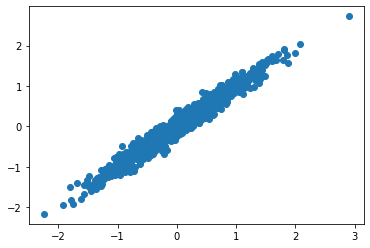

In [3]:
np.random.seed(42)
n = 1000

mu, sigma_prior = 0, 1 # mean and standard deviation
Z = np.random.normal(mu, sigma_prior, n)  # n muestras de la a priori
W = np.array([[1],[1]])
W=W/np.sqrt(2)  # vector unitario de tamaño 2x1

sigma_noise=0.1

# Generamos las muestras. Cada columna de X que tiene tamaño 2xn contendrá una
X = Z*W+np.random.normal(mu,sigma_noise,n*2).reshape(2,n) 

plt.plot(X[0],X[1],'o')


Usando solo las observaciones X, ¿Cómo estimarías W, sigma_noise y dado un x la distribución p(z|x) mediante la trampa de la reparametrización?

Como estamos intentando emular un modelo PPCA supondremos que $p(z|x)={\cal N}(m_1x_1+m_2x_x,(\mbox{sigma_post})^2)$ y tendrás que estimar $m_1$, $m_2$ y $\mbox{sigma_post}$. Obviamente no puedes usar una VAE para este problema. Debes usar la fórmula de la divergencia de Kullback-Leibler y el muestreo solo usarlo para la parte de las observaciones. Puedes usar como tamaño de batch el conjunto completo de muestras. Explica en el código los pasos que vas dando.

<div class="alert alert-block alert-info">
<b> Estima W, sigma_noise, $m_1$, $m_2$ y sigma_post usando la trampa de la reparametrización</b>
</div>


In [ ]:
# Tu respuesta.